In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [20]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [21]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [22]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [23]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [24]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

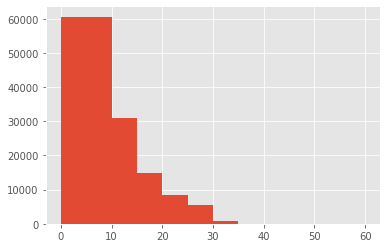

121281


In [25]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=30 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [26]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4             bom produto deixou tv qualidade imagem
1                    5        entrega super rapida produto qualidade amei
2                    5  produto excelente otima qualidade designer mar...
3                    4  verdadeiro bbb bom bonito barato unico problem...
4                    4  filha adorou boneca ficou contente produto boa...
...                ...                                                ...
132368               4       boa qualidade bom acabamento recomendo todos
132369               5  atendeu todas expectativas otimo produto recom...
132370               1  chegou todo rasgado americanas nao quer trocar...
132371               1  bom dia recebi produto defeito tela ja pedi ca...
132372               5  site americanas melhorou ver xxxxxxxxxxx xxxxx...

[132373 rows x 2 columns]>


In [27]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [28]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [29]:
b2wCorpus.shape

(132373, 3)

In [30]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 5].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 30].index)

In [31]:
b2wCorpus.shape

(118454, 3)

In [34]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [32]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [33]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

IndexError: positional indexers are out-of-bounds

In [ ]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

In [ ]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

In [ ]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

In [ ]:
# Treino, Validação e teste

x = b2wCorpus[['review_text']].values
y = b2wCorpus[['overall_rating']].values

print((b2wCorpus.overall_rating.value_counts()/ b2wCorpus.shape[0]).sort_index())

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
#Tokenizando
vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)